In [1]:
# example parameters
directory = '../../output.ibd2'
name = 'SRS104400_110.fna.gz'
render='svg'

In [2]:
if not render: render_name = None
else: render_name = render

In [3]:
import os.path
import collections

import plotly.graph_objects as go

import sourmash
from charcoal import utils
from charcoal.figs.sourmash_sankey import GenomeSankeyFlow

In [4]:
from IPython.display import Markdown as md
md(f"# Charcoal summary report for genome `{name}`")

# Charcoal summary report for genome `SRS104400_110.fna.gz`

In [5]:
import os
from charcoal import utils

## How clean and dirty content changes by taxon

In [6]:
def plot_genome_area_chart(genome, summary):
    row = summary[genome]

    x=['superkingdom', 'phylum', 'class', 'order', 'family', 'genus']

    y_ignored_bp = []
    y_noident_bp = []
    y_clean_bp = []
    y_dirty_bp = []

    ignored_bp = int(row['ignored_contigs_bp'])
    noident_bp = int(row['noident_contigs_bp'])

    for rank in x:
        tax_good_bp = int(row[f'good_{rank}_bp'])
        tax_bad_bp = int(row[f'bad_{rank}_bp'])

        y_ignored_bp.append(ignored_bp)
        y_noident_bp.append(noident_bp)
        y_clean_bp.append(tax_good_bp)
        y_dirty_bp.append(tax_bad_bp)


    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=x, y=y_clean_bp,
        mode='lines',
        line=dict(width=0.5, color='rgb(184, 247, 212)'),
        stackgroup='one',
        name='clean bp',
        groupnorm='percent' # sets the normalization for the sum of the stackgroup
    ))
    fig.add_trace(go.Scatter(
        x=x, y=y_noident_bp,
        mode='lines',
        line=dict(width=0.5, color='rgb(111, 231, 219)'),
        stackgroup='one',
        name='no ident'
    ))
    fig.add_trace(go.Scatter(
        x=x, y=y_ignored_bp,
        mode='lines',
        line=dict(width=0.5, color='rgb(127, 166, 238)'),
        stackgroup='one',
        name='no hashes (ignored)'
    ))
    fig.add_trace(go.Scatter(
        x=x, y=y_dirty_bp,
        mode='lines',
        line=dict(width=0.5, color='rgb(131, 90, 241)'),
        stackgroup='one',
        name='dirty bp'
    ))

    fig.update_layout(
        showlegend=True,
        xaxis_type='category',
        yaxis=dict(
            type='linear',
            range=[1, 100],
            ticksuffix='%'))
    
    title = genome
    fig.update_layout(template='plotly',
                      title=title)

    return fig

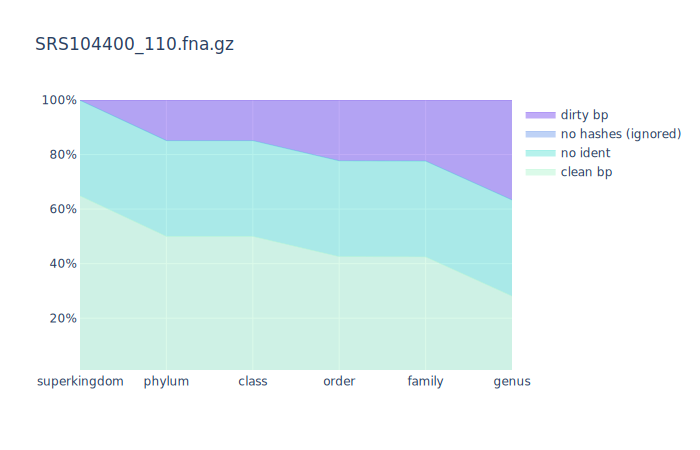

In [7]:
summary_csv = f'{directory}/genome_summary.csv'
summary = utils.CSV_DictHelper(summary_csv, 'genome')
fig = plot_genome_area_chart(name, summary)
fig.show(render_name)

## Taxonomic assignments across ranks

In [8]:
def make_plotly_fig(obj, title):
    "Build a plotly figure/sankey diagram."
    # make the data to go into the sankey figure.
    labels = obj.make_labels()
    src_l, dest_l, cnt_l, color_l, label_l = obj.make_lists()

    # build figure
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = "blue"
        ),
        link = dict(
          source = src_l,
          target = dest_l,
          value = cnt_l,
          color = color_l,
          label = label_l,
      ))])

    if title:
        fig.update_layout(title_text=title, font_size=10)

    return fig

In [9]:
def make_plotly_fig(obj, title):
    "Build a plotly figure/sankey diagram."
    # make the data to go into the sankey figure.
    labels = obj.make_labels()
    src_l, dest_l, cnt_l, color_l, label_l = obj.make_lists()

    # build figure
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = "blue"
        ),
        link = dict(
          source = src_l,
          target = dest_l,
          value = cnt_l,
          color = color_l,
          label = label_l,
      ))])

    if title:
        fig.update_layout(title_text=title, font_size=10)

    return fig


def make_flow_fig(title, genome_lineage, contigs_info):
    obj = GenomeSankeyFlow()
    
    counts = collections.Counter()
    for contig_name, gather_info in contigs_info.items():
        contig_taxlist = gather_info.gather_tax

        # iterate over each contig match and summarize counts.              
        # note - here we can stop at first one, or track them all.          
        # note - b/c gather counts each hash only once, these               
        #     are non-overlapping                                           
        total_hashcount = 0
        for lin, hashcount in contig_taxlist:
            counts[lin] += hashcount
            total_hashcount += hashcount

        # track missing => unassigned lineage
        unident = gather_info.num_hashes - total_hashcount
        counts[obj.unassigned_lin] += unident

    # extend genome_lineage ranks
    last_genome_rank = genome_lineage[-1].rank
    taxlist = list(sourmash.lca.taxlist())[:-2]
    assert taxlist[-1] == 'genus', taxlist
    
    for rank in taxlist[len(genome_lineage):]:
        genome_lineage.append(sourmash.lca.LineagePair(rank=rank, name='unassigned'))
    
    # set the color of the main lineage
    genome_lineage = tuple(genome_lineage)
    obj.colors[genome_lineage] = "lightseagreen"
    
    # for phylum level disagreements, let's go with palevioletred
    for lin in counts:
        if not utils.is_lineage_match(lin, genome_lineage, 'phylum'):
            obj.colors[lin] = 'palevioletred'
            
    # assign unassigned to good lineage, maybe?
    counts[genome_lineage] += counts[obj.unassigned_lin]
    del counts[obj.unassigned_lin]
    
    obj.make_links(genome_lineage, counts)
    fig = make_plotly_fig(obj, title)
    
    return fig

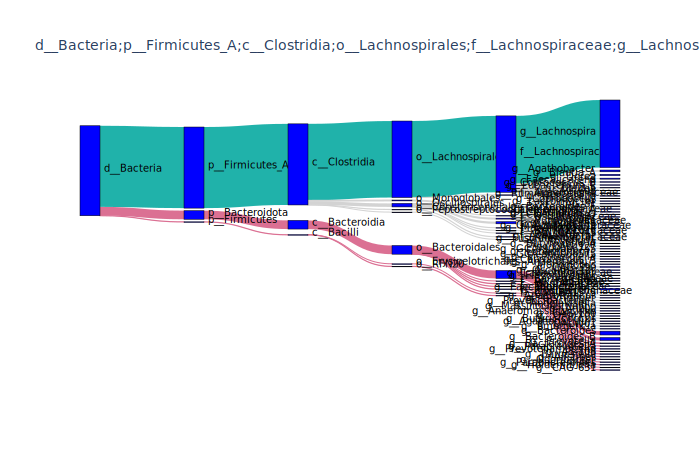

In [10]:
contigs_filename = f'{directory}/{name}.contigs-tax.json'

summary = utils.CSV_DictHelper(summary_csv, 'genome')
row = summary[name]
genome_lineage = utils.make_lineage(row.lineage)

contigs_info = utils.load_contigs_gather_json(contigs_filename)

title = sourmash.lca.display_lineage(genome_lineage)
fig = make_flow_fig(title, genome_lineage, contigs_info)
fig.show(render_name)